In [47]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy import log

ANGLE = 0.7 # 70 %
TOP_LENGTH = 180
TOP_WIDTH = 72
DEPTH = 14.5

TOP_AREA = TOP_LENGTH * TOP_WIDTH

BOTTOM_LENGTH = TOP_LENGTH - 2 * ANGLE * DEPTH
BOTTOM_WIDTH = TOP_WIDTH - 2 * ANGLE * DEPTH

def area(d: float) -> float:
    ''' Computes the "surface" area as a function of depth d (PTES)'''
    l = TOP_LENGTH - 2 * ANGLE * d
    w = TOP_WIDTH - 2 * ANGLE * d
    return l * w

def volume(d: float) -> float:
    ''' Computes the volume as a function of depth d (PTES)'''
    area_top = area(0)
    area_d = area(d)
    return 1/3 * d * (area_top + area_d + np.sqrt(area_top * area_d))

def density(t: float) -> float:
    ''' Computes the density of water as a function of temperature t [kg/m^3]'''
    return 1000.6 - 0.0128*pow(t, 1.76)

def specific_heat(t: float) -> float:
    ''' Computes the specific heat of water as a function of temperature t [J/(kg*K)]'''
    return 4209.1 - 1.328 * t + 0.01432 * t**2

def logistic_temp(d: float, t0: float = 50, t1: float = 85, k: float = 10, a: float = DEPTH / 2) -> float:
    ''' Computes the temperature as a function of depth d using a logistic function
        Note: k is the steepness of the curve, a is the inflection point (k >= 0)
    '''
    return t0 + (t1 - t0) / (1 + np.exp(k * (d - a)))

def mass(d: float) -> float:
    ''' Computes the mass of water as a function of depth d (PTES)'''
    return volume(d) * density(logistic_temp(d))

def volumne_to_depth(v: float) -> float:
    ''' Computes the depth of water as a function of volume v (PTES)'''
    return ((3*TOP_LENGTH)/8 + (3*TOP_WIDTH)/8 - np.sqrt((9*TOP_LENGTH**2 - 21.65*TOP_LENGTH*TOP_WIDTH + 9*TOP_WIDTH**2)/8))/ANGLE


volume(14)



148408.54585813207

In [20]:
9*TOP_LENGTH**2 - 30*TOP_LENGTH*TOP_WIDTH + 9*TOP_WIDTH**2

-50544

# Vi leger lige at det bare er en kasse :P

In [49]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy import log


L = 180
W = 72
D = 14.5
A = L * W



def area(d: float) -> float:
    ''' Computes the "surface" area as a function of depth d (PTES)'''
    return L * W

def volume(d: float) -> float:
    ''' Computes the volume as a function of depth d (PTES)'''
    return L * W * d

def density(t: float) -> float:
    ''' Computes the density of water as a function of temperature t [kg/m^3]'''
    return 1000.6 - 0.0128*pow(t, 1.76)

def specific_heat(t: float) -> float:
    ''' Computes the specific heat of water as a function of temperature t [J/(kg*K)]'''
    return 4209.1 - 1.328 * t + 0.01432 * t**2

def logistic_temp(d: float, t0: float = 50, t1: float = 85, k: float = 10, a: float = DEPTH / 2) -> float:
    ''' Computes the temperature as a function of depth d using a logistic function
        Note: k is the steepness of the curve, a is the inflection point (k >= 0)
    '''
    return t0 + (t1 - t0) / (1 + np.exp(k * (d - a)))

def mass(d: float) -> float:
    ''' Computes the mass of water as a function of depth d (PTES)'''
    return volume(d) * density(logistic_temp(d))

def volumne_to_depth(v: float) -> float:
    ''' Computes the depth of water as a function of volume v (PTES)'''
    return v / (L * W)






14.0

# Likelihooodd :)))))




In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from tqdm import tqdm

df = pd.read_csv('../data/processed/data_depths.csv', index_col=0)
times = df.EVENT_TIME.sort_values().unique()
min, max = 50, 90

drop_idx = [86,322,323] # Corrupteed data points :(((
drop_times = times[drop_idx]
df = df[~df.EVENT_TIME.isin(drop_times)]
times = df.EVENT_TIME.sort_values().unique()




def get_timestep(df: pd.DataFrame, t: int) -> pd.DataFrame:
    ''' Returns the dataframe for the given timestep t'''
    df = df[df.EVENT_TIME == times[t]]
    inlet, outlet = df[df.POINT_NAME == '/Net-H/VEKS/LERVV/VAK/FTDVTIL/M3H'].VALUE_CUR.values[0], df[df.POINT_NAME == '/Net-H/VEKS/LERVV/VAK/FTDVFRA/M3H'].VALUE_CUR.values[0]

    temp, d = df[df.DEPTHS > 0.5].VALUE_CUR, df[df.DEPTHS > 0.5].DEPTHS
    temp = (temp - min) / (max - min)
    d = (d - d.max()) / (d.min() - d.max())
    
    return inlet, outlet, temp, d


def logistic(d: float, t: float = 85, k: float = 10, a: float = 0.5):
    ''' Computes the temperature as a function of depth d using a logistic function
        Note: k is the steepness of the curve, a is the inflection point (k >= 0)
    '''
    return t / (1 + np.exp( (a-d) / k))

def logistic_temp(d: float, t0: float = 50, t1: float = 30, k1: float = 0.5, a1: float = 0.5, t2: float = 10, k2: float = 0.5, a2: float = 0.5) -> float:
    ''' Computes the temperature as a function of depth d using a logistic function
        Note: k is the steepness of the curve, a is the inflection point (k >= 0)
    '''

    l1 = logistic(d, t1, k1, a1)
    l2 = logistic(d, t2, k2, a2)

    return t0 + l1 + l2

def MSE(temp: np.ndarray, pred: np.ndarray, *args) -> float:
    ''' Computes the mean squared error between the true and predicted values'''
    return np.mean((temp - pred)**2)


def l2_loss(temp: np.ndarray, pred: np.ndarray, *args) -> float:
    ''' Computes the loss function'''
    mse = MSE(temp, pred)
    params = np.array(args)
    return mse + 0.001 * np.sum(params**2)



def l1_loss(temp: np.ndarray, pred: np.ndarray, *args) -> float:
    ''' Computes the loss function'''
    mse = MSE(temp, pred)
    params = np.array(args)
    return mse + 0.001 * np.sum(np.abs(params))


def loss(params: np.ndarray, temp: np.ndarray, d: np.ndarray, criterion: callable = MSE) -> float:
    ''' Computes the loss function'''
    return criterion(temp, logistic_temp(d, *params), *params)




In [354]:

N = len(times)
M = 7
P = np.zeros((N, M))
initial = [0.1, 0.8, 1e-2, 0.5, 0.1, 1e-2, 0.8]
I, O = np.zeros(N), np.zeros(N)
for t in tqdm(range(N)):
    
    inlet, outlet, temp, d = get_timestep(df, t)
    params = opt.minimize(loss, x0=initial, args=(temp, d, MSE),
                          bounds = [(0, 1), (0, 1), (1e-4, 2), (0, 1), (0, 0.2), (1e-4, 2), (0, 3)],
                          # constraints=({'type': 'ineq', 'fun': lambda x:  x[1]-x[4]}),
                        #                {'type': 'ineq', 'fun': lambda x:  x[0] + x[1] + x[4] - 1},
                        #                {'type': 'ineq', 'fun': lambda x:  x[1] - x[4]},)
                                       ).x
    P[t] = params
    I[t], O[t] = inlet, outlet
    initial = params
    # initial[3], initial[6] = 0.5, 0.9


 55%|█████▌    | 337/609 [00:40<00:26, 10.46it/s]c:\Users\peter\miniconda3\envs\thesis_project\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 609/609 [01:21<00:00,  7.48it/s]


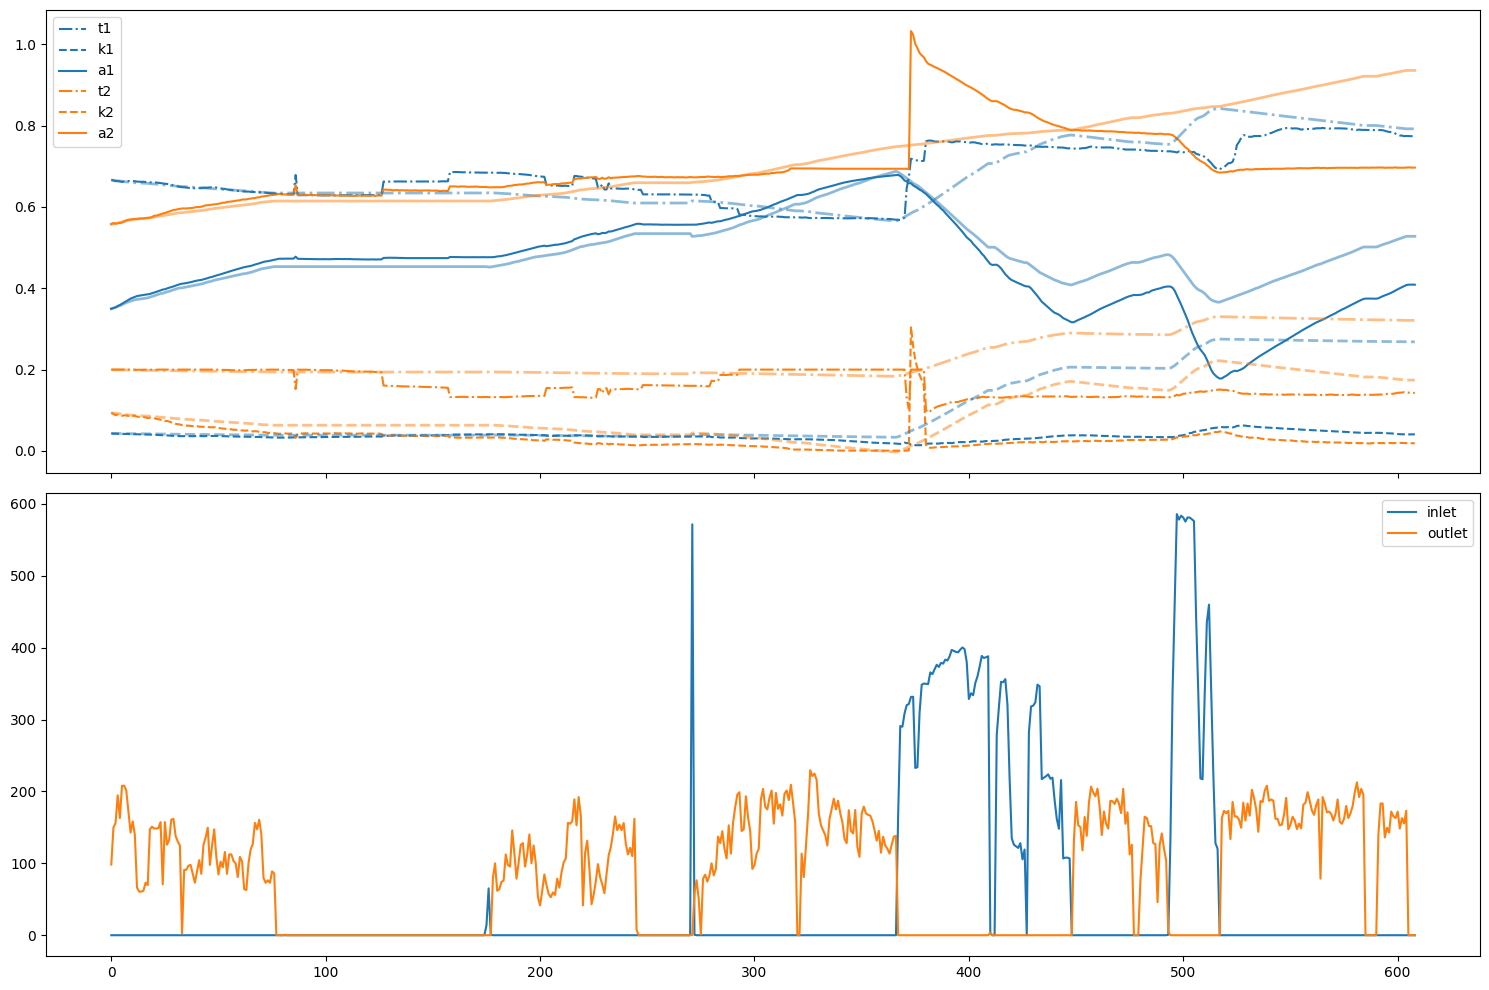

In [696]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
# ax.plot(P[:, 0], label='t0')
ax[0].plot(P[:, 1], label='t1', c = 'C0', linestyle='-.')
ax[0].plot(P[:, 2], label='k1', c = 'C0', linestyle='--')
ax[0].plot(P[:, 3], label='a1', c = 'C0')
ax[0].plot(P[:, 4], label='t2', c = 'C1', linestyle='-.')
ax[0].plot(P[:, 5], label='k2', c = 'C1', linestyle='--')
ax[0].plot(P[:, 6], label='a2', c = 'C1')

ax[0].legend()





ax[1].plot(I, label='inlet')
ax[1].plot(O, label='outlet')
ax[1].legend()
fig.tight_layout()



232.69999695 0.0
t0:  0.0574 t1:  0.715 k1:  0.0141 a1:  0.6498 t2:  0.2 k2:  0.2238 a2:  1.0009


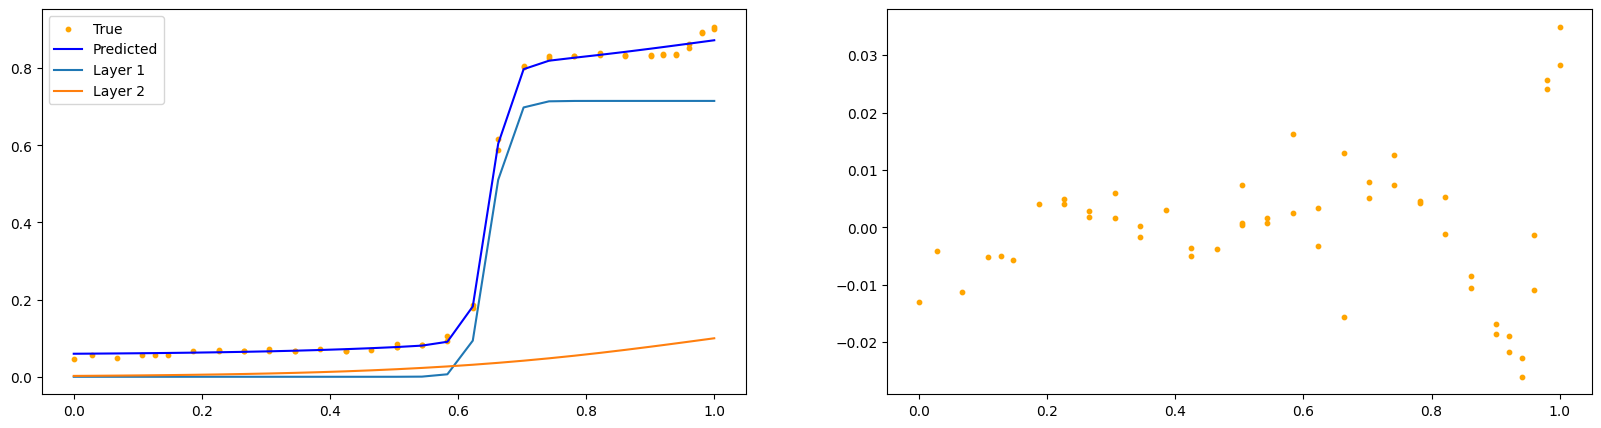

In [614]:

t = 375


inlet, outlet, temp, d = get_timestep(df, t)
params = P[t]
pred = logistic_temp(d, *params)


l1 = logistic(d, *params[1:4])
l2 = logistic(d, *params[4:])
idx = np.argsort(d)
d = d.values[idx]
temp = temp.values[idx]
pred = pred.values[idx]
l1 = l1.values[idx]
l2 = l2.values[idx]



fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].scatter(d, temp, label='True', s=10, c = 'orange')
ax[0].plot(d, pred, label='Predicted', c = 'blue')

ax[0].plot(d, l1, label='Layer 1')
ax[0].plot(d, l2, label='Layer 2')
ax[0].legend()

ax[1].scatter(d, temp - pred, label='Residuals', s=10, c = 'orange')
print(inlet, outlet)

print("t0: ", round(params[0],4), "t1: ", round(params[1],4), "k1: ", round(params[2],4), "a1: ", round(params[3],4), "t2: ", round(params[4],4), "k2: ", round(params[5],4), "a2: ", round(params[6],4))

MovieWriter Pillow unavailable; using Pillow instead.


c:\Users\peter\miniconda3\envs\thesis_project\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\peter\miniconda3\envs\thesis_project\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\peter\miniconda3\envs\thesis_project\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\peter\miniconda3\envs\thesis_project\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\peter\miniconda3\envs\thesis_project\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\peter\miniconda3\envs\thesis_project

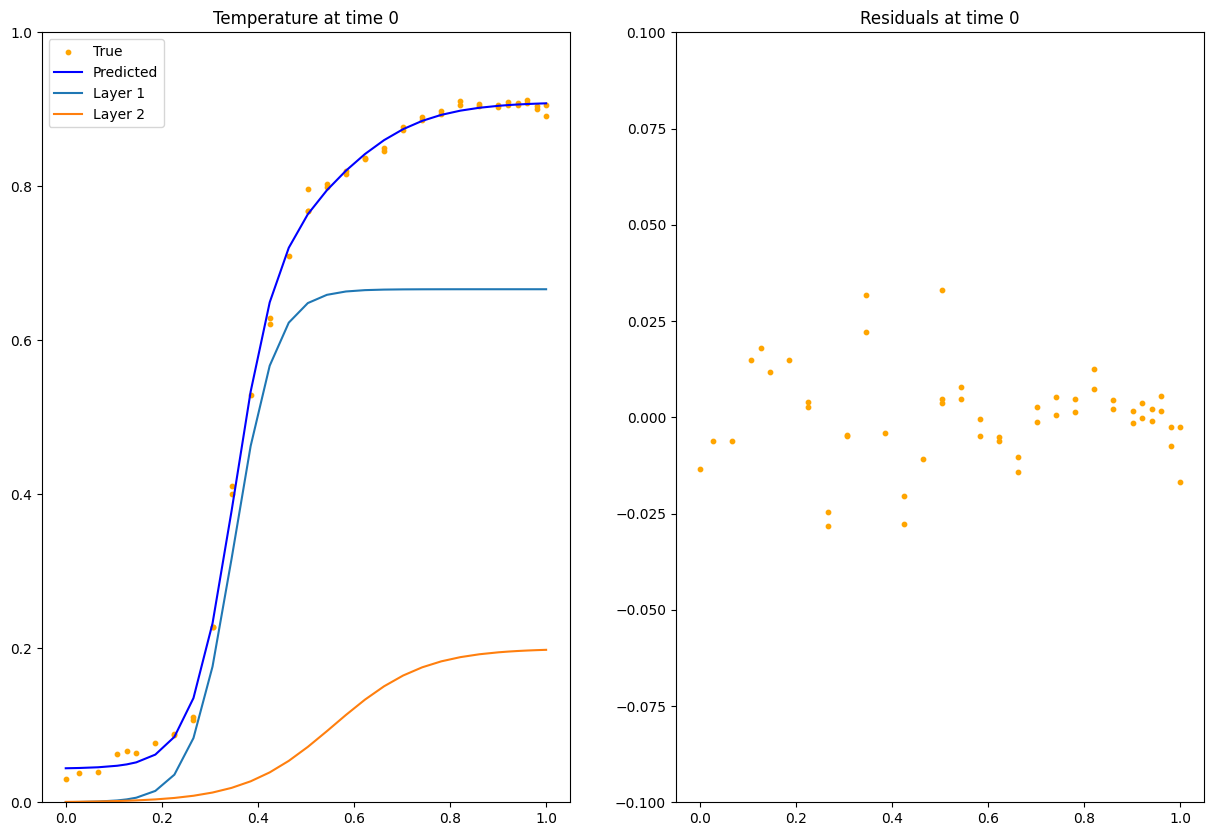

In [341]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from functools import partial
import pandas as pd

fig, ax = plt.subplots(1,2, figsize=(15, 10))


def animate(i):
    ax[0].clear()
    ax[1].clear()


    inlet, outlet, temp, d = get_timestep(df, i)
    params = P[i]
    pred = logistic_temp(d, *params)


    l1 = logistic(d, *params[1:4])
    l2 = logistic(d, *params[4:])
    idx = np.argsort(d)
    d = d.values[idx]
    temp = temp.values[idx]
    pred = pred.values[idx]
    l1 = l1.values[idx]
    l2 = l2.values[idx]
    
    ax[0].scatter(d, temp, label='True', s=10, c = 'orange')
    ax[0].plot(d, pred, label='Predicted', c = 'blue')

    ax[0].plot(d, l1, label='Layer 1')
    ax[0].plot(d, l2, label='Layer 2')
    ax[0].legend()

    ax[1].scatter(d, temp - pred, label='Residuals', s=10, c = 'orange')


    ax[0].set_ylim(0, 1)
    ax[0].set_title(f"Temperature at time {i}")

    ax[1].set_ylim(-0.1, 0.1)
    ax[1].set_title(f"Residuals at time {i}")



ani = FuncAnimation(fig, animate, frames=len(times), interval=2, repeat=True)
# Save as gif
ani.save('animation_2.gif', writer='Pillow', fps=40)









# Params

In [618]:
t0, t1, k1, a1, t2, k2, a2 = P[:,0], P[:,1], P[:,2], P[:,3], P[:,4], P[:,5], P[:,6]

temperatures = np.zeros((len(times), 52))
for i in range(len(times)):
    inlet, outlet, temp, d = get_timestep(df, i)
    
    temperatures[i] = temp

In [763]:




def rk4(f, t, y, u, dt, *args):
    ''' Compute the solution of y' = f(t, y) at t + dt using Runge-Kutta method'''
    k1 = dt * f(t, y, u, *args)
    k2 = dt * f(t + dt/2, y + k1/2, u, *args)
    k3 = dt * f(t + dt/2, y + k2/2, u, *args)
    k4 = dt * f(t + dt, y + k3,u,  *args)
    return y + 1/6 * (k1 + 2*k2 + 2*k3 + k4)


def euler(f, t, y, u, dt, *args):
    ''' Compute the solution of y' = f(t, y) at t + dt using Euler method'''
    return y + dt * f(t, y, u, *args)


def MSE(true: np.ndarray, pred: np.ndarray, *args) -> float:
    ''' Computes the mean squared error between the true and predicted values'''
    return np.mean((true - pred)**2)


def ode(t, y, u, theta):
    ''' Computes the derivative of the function y(t) = exp(-kt)'''
    u_in, u_out = u
    return theta[0] * y * (theta[1]- y / theta[2]) + (theta[3] * u_in + theta[4] * u_out)

def simulate(params: np.ndarray, u: np.ndarray, y0: float, dt: float) -> np.ndarray:
    ''' Simulates the system using the given parameters'''
    y = np.zeros(len(u))
    y[0] = y0
    for i in range(1, len(u)):
        y[i] = euler(ode, i, y[i-1], u[i], dt, params)
    return y


# Optimize
def loss(params: np.ndarray, u, y0, dt, criterion: callable = MSE) -> float:
    ''' Computes the loss function'''

    # simulate
    
    coef = np.zeros((7, N_steps))
    params = params.reshape(7, -1)
    for i in range(7):
        y = simulate(params[i], u, y0[i], dt)
        coef[i] = y
    
    loss = 0
    for t in range(N_steps):
        true = temperatures[t]
        pred = logistic_temp(d, *coef[:, t])
        loss += criterion(true, pred)
    
    return loss

n_pars = 5
N_steps = 100
init_coef = np.array([0.1, 0.8, 1, 1e-6, 1e-6] * 7)
u = np.array([I, O]).T[:N_steps]
y0 = P[0]


params = opt.minimize(loss, x0=init_coef, args=(u, y0, 1, MSE),
                      # callback n iter
                    #   callback=print,
                        bounds = [(0, 1), (0, 1), (1, 2), (-1e-5, 1e-5), (-1e-5, 1e-5)] * 7,
                      ).x

params.reshape(7, -1)

c:\Users\peter\miniconda3\envs\thesis_project\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [760]:
params

array([[1.e-01, 8.e-01, 1.e+00, 1.e-05, 1.e-05],
       [1.e-01, 8.e-01, 1.e+00, 1.e-05, 1.e-05],
       [1.e-01, 8.e-01, 1.e+00, 1.e-05, 1.e-05],
       [1.e-01, 8.e-01, 1.e+00, 1.e-05, 1.e-05],
       [1.e-01, 8.e-01, 1.e+00, 1.e-05, 1.e-05],
       [1.e-01, 8.e-01, 1.e+00, 1.e-05, 1.e-05],
       [1.e-01, 8.e-01, 1.e+00, 1.e-05, 1.e-05]])

(7, 5)


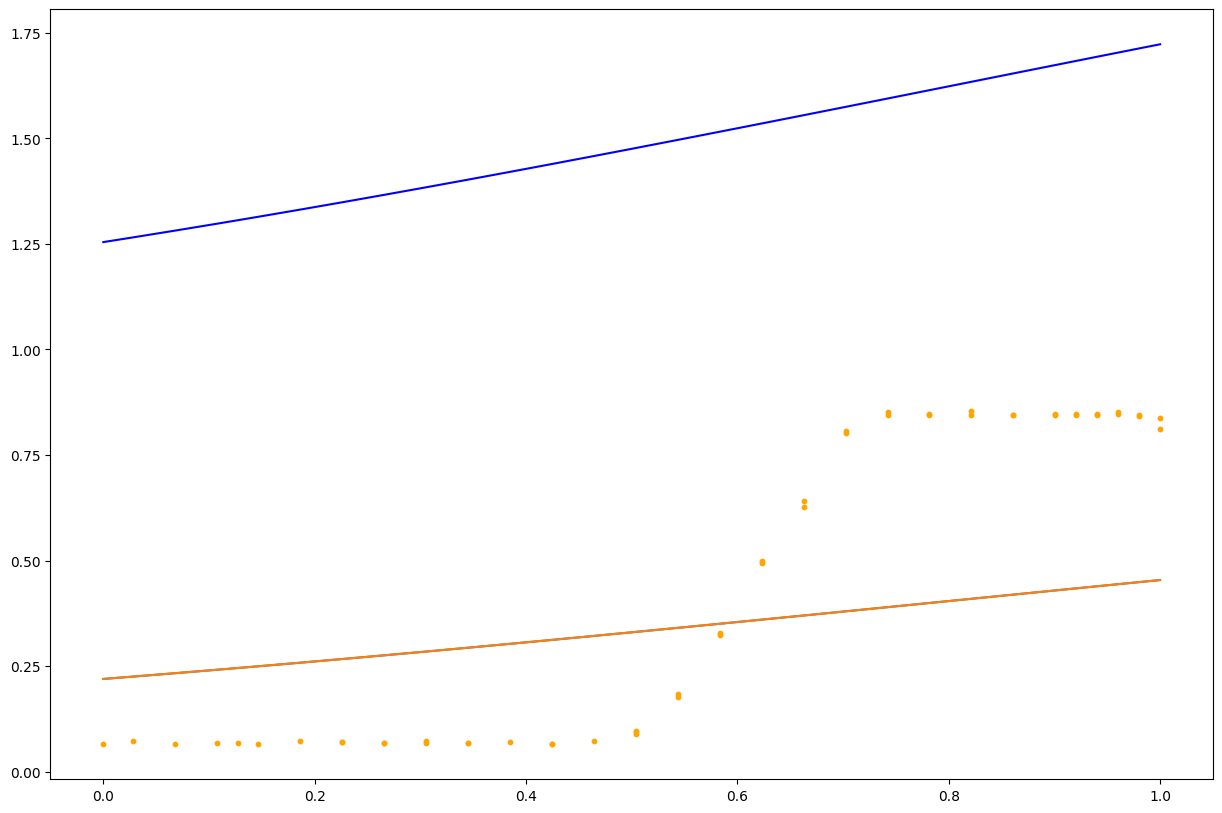

In [755]:
N_steps = N
coef = np.zeros((7, N_steps))
params = params.reshape(7, -1)
u = np.array([I, O]).T[:N_steps]
for i in range(7):
    y = simulate(params[i], u, y0[i], 1)
    coef[i] = y

preds = np.zeros((N_steps, 52))
for t in range(N_steps):
    true = temperatures[t]
    pred = logistic_temp(d, *coef[:, t])
    preds[t] = pred


t = 300
print(params.shape)
idx = np.argsort(d)
d_ = d.values[idx]
true = temperatures[t][idx]
preds = preds[:, idx]
l1 = logistic(d, *coef[1:4, t])
l2 = logistic(d, *coef[4:, t])

l1 = l1.values[idx]
l2 = l2.values[idx]

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(d_, preds[t], label='Predicted', c = 'blue')
ax.scatter(d_, true, label='True', s=10, c = 'orange')
ax.plot(d_, l1, label='Layer 1')
ax.plot(d_, l2, label='Layer 2')


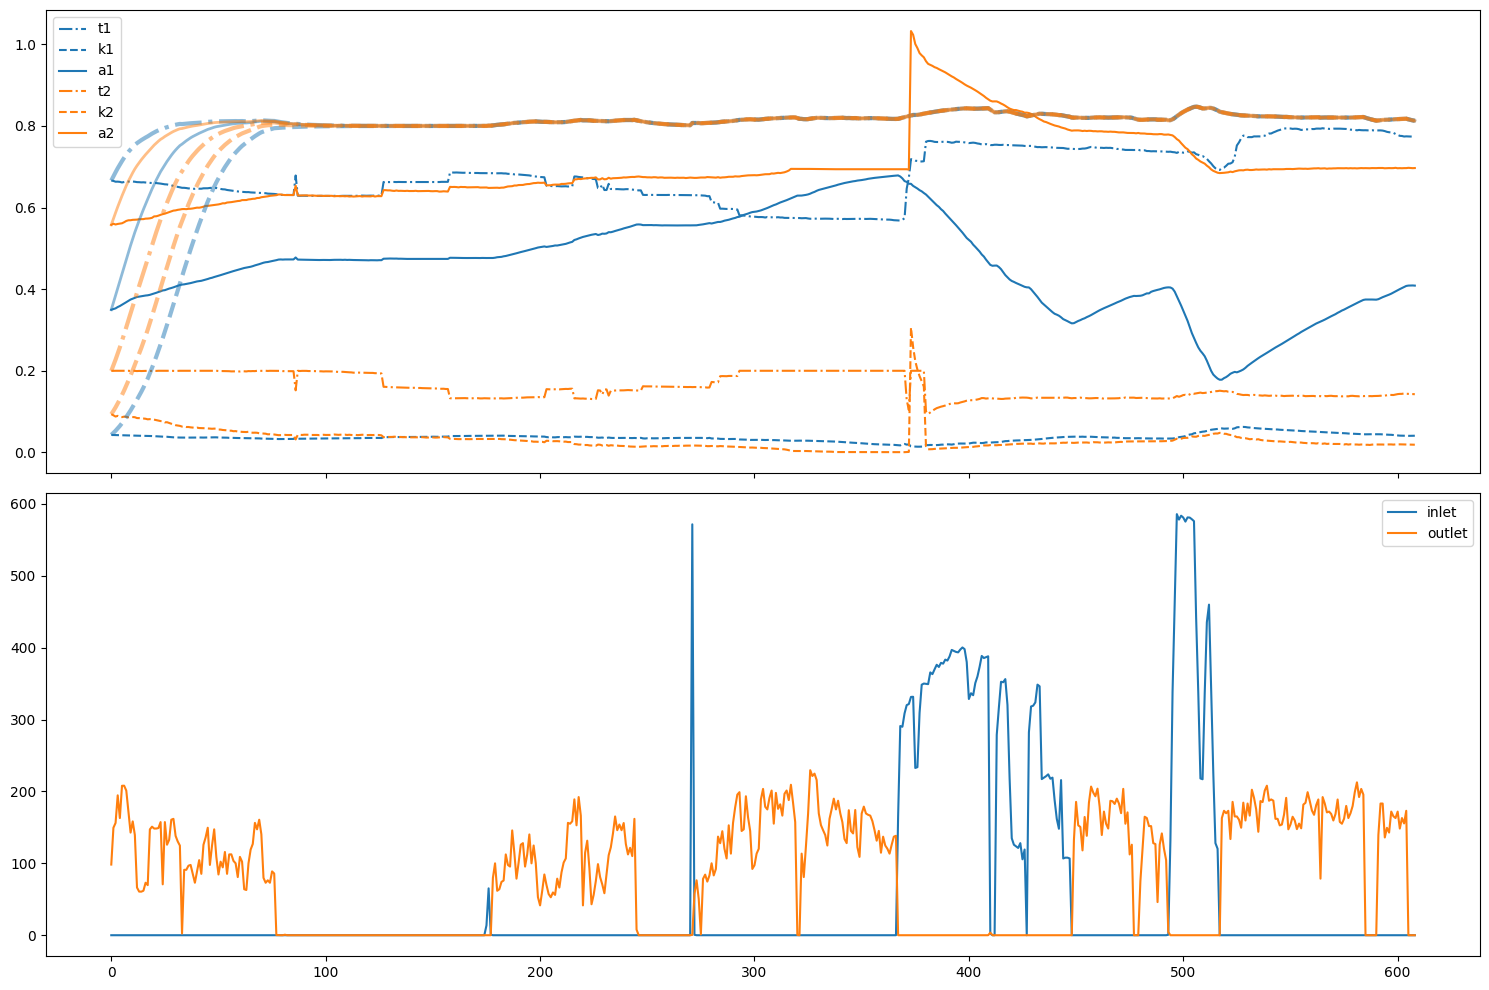

In [756]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
# ax.plot(P[:, 0], label='t0')
ax[0].plot(P[:, 1], label='t1', c = 'C0', linestyle='-.')
ax[0].plot(P[:, 2], label='k1', c = 'C0', linestyle='--')
ax[0].plot(P[:, 3], label='a1', c = 'C0')
ax[0].plot(P[:, 4], label='t2', c = 'C1', linestyle='-.')
ax[0].plot(P[:, 5], label='k2', c = 'C1', linestyle='--')
ax[0].plot(P[:, 6], label='a2', c = 'C1')

ax[0].legend()


ax[0].plot(coef[1], label='t1', c = 'C0', linestyle='-.', linewidth=3, alpha = 0.5)
ax[0].plot(coef[2], label='k1', c = 'C0', linestyle='--', linewidth=3, alpha = 0.5)
ax[0].plot(coef[3], label='a1', c = 'C0', linewidth=2, alpha = 0.5)

ax[0].plot(coef[4], label='t2', c = 'C1', linestyle='-.', linewidth=3, alpha = 0.5)
ax[0].plot(coef[5], label='k2', c = 'C1', linestyle='--', linewidth=3, alpha = 0.5)
ax[0].plot(coef[6], label='a2', c = 'C1', linewidth=2, alpha = 0.5)


ax[1].plot(I, label='inlet')
ax[1].plot(O, label='outlet')
ax[1].legend()
fig.tight_layout()



In [744]:
coef[0]

array([ 4.34571016e-002,  4.32397074e-002,  4.28498799e-002,
        4.15327624e-002,  4.08616843e-002,  3.90907524e-002,
        3.71900871e-002,  3.53112853e-002,  3.39799188e-002,
        3.32353476e-002,  3.20708519e-002,  3.12659434e-002,
        3.21141024e-002,  3.31558527e-002,  3.42764114e-002,
        3.54485273e-002,  3.64461486e-002,  3.75936359e-002,
        3.70089748e-002,  3.62929321e-002,  3.55858080e-002,
        3.48272469e-002,  3.39969992e-002,  3.29116847e-002,
        3.37754144e-002,  3.26738905e-002,  3.22295035e-002,
        3.15931976e-002,  3.02542182e-002,  2.87883887e-002,
        2.77692056e-002,  2.68570338e-002,  2.60104551e-002,
        2.79654592e-002,  2.79907908e-002,  2.80180054e-002,
        2.79137251e-002,  2.77759266e-002,  2.79183410e-002,
        2.83618043e-002,  2.84681154e-002,  2.82145606e-002,
        2.83895779e-002,  2.76312583e-002,  2.65776501e-002,
        2.51293155e-002,  2.47837362e-002,  2.37798092e-002,
        2.21734738e-002,